### Investigate additional relationships between subclonal RT shifts and other features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import scale
from scdna_replication_tools.plot_utils import plot_cell_cn_profile2, get_clone_cmap


In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

In [3]:
df = pd.read_csv('../../analysis/sig_lines/subclonal_rt_diffs_summary.tsv', sep='\t')
df.head()

,chr,start,end,reference_rt,clone_rt,clone_rt_diff,clone_cna_type,reference_freq,clone_freq,dataset
0,11,66000001,66500000,1.210421,1.061797,-0.148625,gain,0.996960,0.542373,SA039
1,11,66500001,67000000,1.209055,1.135885,-0.073170,gain,0.997333,0.994350,SA039
2,11,67000001,67500000,1.206959,1.129149,-0.077809,gain,0.997333,0.996234,SA039
3,11,67500001,68000000,1.134819,1.088738,-0.046081,gain,0.997333,0.996234,SA039
4,11,68000001,68500000,1.105117,1.061797,-0.043321,gain,0.997333,0.996234,SA039


In [4]:
# filter this dataframe to only consider CNAs that have >95% frequency within their given clone
df = df[df['clone_freq'] > 0.98]

In [5]:
df.dataset.unique()

array(['SA039', 'SA906a', 'SA906b', 'SA1188', 'SA1292', 'SA1056',
       'SA1055', 'SA1054'], dtype=object)

In [6]:
df.chr.unique()

array(['11', '20', '22', '8', '1', '10', '12', '13', '14', '15', '16',
       '17', '18', '19', '2', '21', '3', '4', '5', '6', '7', '9', 'X'],
      dtype=object)

In [7]:
df.clone_cna_type.unique()

array(['gain', 'loss', 'unaltered'], dtype=object)

In [8]:
def get_cna_cmap():
    ''' Global color map for copy number alterations '''
    cmap = {
        'gain': 'red',  # red
        'loss': 'deepskyblue',  # dark blue
        'neutral': '#CCCCCC',  # grey
        'unaltered': '#CCCCCC'  # grey
    }
    return cmap

### Instead of looking at the RT distribution shift as a function of reference RT, look at the distribution within each unique CNA

In [9]:
# assume that there is only one CNA per unique combination of chr, dataset, and clone_cna_type
unique_events = df[['chr', 'dataset', 'clone_cna_type']].drop_duplicates().reset_index(drop=True)

# loop through each unique event and plot the relationship between reference_rt and clone_rt_diff
unique_events['mean_rt_diff'] = np.nan
unique_events['median_rt_diff'] = np.nan
unique_events['std_rt_diff'] = np.nan
unique_events['event_size'] = np.nan
for i, row in unique_events.iterrows():
    temp_df = df[(df.chr == row.chr) & (df.dataset == row.dataset) & (df.clone_cna_type == row.clone_cna_type)]
    # compute the mean, median, and std of clone_rt_diff for this event, and add them to the unique_events df
    unique_events.loc[i, 'mean_rt_diff'] = temp_df.clone_rt_diff.mean()
    unique_events.loc[i, 'median_rt_diff'] = temp_df.clone_rt_diff.median()
    unique_events.loc[i, 'std_rt_diff'] = temp_df.clone_rt_diff.std()
    # the bin size is the number of loci in this event x 500kb
    unique_events.loc[i, 'event_size'] = temp_df.shape[0] * 500000

unique_events.head()

,chr,dataset,clone_cna_type,mean_rt_diff,median_rt_diff,std_rt_diff,event_size
0,11,SA039,gain,-0.039528,-0.044469,0.104537,66000000.0
1,20,SA039,gain,-0.062595,-0.077593,0.139503,31500000.0
2,22,SA039,loss,-0.000041,-0.040574,0.102002,7500000.0
3,8,SA039,loss,0.166797,0.153416,0.200618,42000000.0
4,8,SA039,gain,-0.033476,-0.012427,0.197071,90500000.0


In [10]:
# find the exact start and end positions of the chr19 loss in SA906b
temp_df = df.loc[(df['dataset']=='SA906b') & (df['chr']=='19') & (df['clone_cna_type']=='loss')]
# find the min of all start values and max of all end values
chr19_loss_start = temp_df.start.min()
chr19_loss_end = temp_df.end.max()
chr19_loss_start, chr19_loss_end

(28000001, 59000000)

In [11]:
# find the exact positions of the chr19 gain in SA906b
temp_df = df.loc[(df['dataset']=='SA906b') & (df['chr']=='19') & (df['clone_cna_type']=='gain')]
# find the min of all start values and max of all end values
chr19_gain_start = temp_df.start.min()
chr19_gain_end = temp_df.end.max()
chr19_gain_start, chr19_gain_end

(5000001, 19000000)

based on this, focus on the chr19 loss event in SA906b as it is the largest event

looking at the copy number heatmaps, this loss is specific to chr6q clone G


In [12]:
# load the pseudobulk RT profiles for SA906b
rt_sa906b = pd.read_csv('../../analysis/sig_lines/SA906b/scRT_pseudobulks.tsv', sep='\t', dtype={'chr': str})
# convert the chr column to a category
rt_sa906b.chr = rt_sa906b.chr.astype('category')
# add a column named end which is 500kb after the start
rt_sa906b['end'] = rt_sa906b.start + 500000 -1
rt_sa906b.head()

,chr,start,pseudobulk_model_rep_state,pseudobulk_hours,pseudobulk_cloneA_model_rep_state,pseudobulk_cloneA_hours,pseudobulk_cloneB_model_rep_state,pseudobulk_cloneB_hours,pseudobulk_cloneC_model_rep_state,pseudobulk_cloneC_hours,...,pseudobulk_cloneH_hours,pseudobulk_cloneI_model_rep_state,pseudobulk_cloneI_hours,pseudobulk_cloneJ_model_rep_state,pseudobulk_cloneJ_hours,pseudobulk_cloneK_model_rep_state,pseudobulk_cloneK_hours,pseudobulk_cloneL_model_rep_state,pseudobulk_cloneL_hours,end
0,1,1000001,0.746946,2.530541,0.860465,1.395349,0.85,1.5,0.871658,1.283422,...,1.428571,0.909091,0.909091,0.750000,2.500000,0.861111,1.388889,0.822086,1.779141,1500000
1,1,1500001,0.861257,1.387435,0.930233,0.697674,0.85,1.5,0.914439,0.855615,...,1.904762,0.954545,0.454545,0.875000,1.250000,0.870370,1.296296,0.834356,1.656442,2000000
2,1,2000001,0.803665,1.963351,0.860465,1.395349,0.90,1.0,0.930481,0.695187,...,1.428571,0.954545,0.454545,0.750000,2.500000,0.888889,1.111111,0.815951,1.840491,2500000
3,1,3000001,0.726876,2.731239,0.767442,2.325581,0.85,1.5,0.807487,1.925134,...,2.380952,0.954545,0.454545,0.708333,2.916667,0.833333,1.666667,0.711656,2.883436,3500000
4,1,4000001,0.746073,2.539267,0.697674,3.023256,0.80,2.0,0.716578,2.834225,...,2.857143,0.931818,0.681818,0.750000,2.500000,0.796296,2.037037,0.601227,3.987730,4500000


In [13]:


# find all the columns containing clone RT profiles
rt_cols = [x for x in rt_sa906b.columns if x.startswith('pseudobulk_clone') and x.endswith('model_rep_state')]
# center and scale all the RT profiles to have mean 0 and std 1
# this is necessary as clones have different distributions of early vs late S-phase cells and
# we don't want to mistake these differences for RT shifts
rt_sa906b[rt_cols] = scale(rt_sa906b[rt_cols], axis=0)
rt_sa906b.head()

,chr,start,pseudobulk_model_rep_state,pseudobulk_hours,pseudobulk_cloneA_model_rep_state,pseudobulk_cloneA_hours,pseudobulk_cloneB_model_rep_state,pseudobulk_cloneB_hours,pseudobulk_cloneC_model_rep_state,pseudobulk_cloneC_hours,...,pseudobulk_cloneH_hours,pseudobulk_cloneI_model_rep_state,pseudobulk_cloneI_hours,pseudobulk_cloneJ_model_rep_state,pseudobulk_cloneJ_hours,pseudobulk_cloneK_model_rep_state,pseudobulk_cloneK_hours,pseudobulk_cloneL_model_rep_state,pseudobulk_cloneL_hours,end
0,1,1000001,0.746946,2.530541,0.865190,1.395349,0.733134,1.5,0.761550,1.283422,...,1.428571,0.404404,0.909091,0.396363,2.500000,0.696135,1.388889,0.951064,1.779141,1500000
1,1,1500001,0.861257,1.387435,1.101763,0.697674,0.733134,1.5,0.907785,0.855615,...,1.904762,0.591703,0.454545,0.798256,1.250000,0.727720,1.296296,0.990859,1.656442,2000000
2,1,2000001,0.803665,1.963351,0.865190,1.395349,0.905828,1.0,0.962624,0.695187,...,1.428571,0.591703,0.454545,0.396363,2.500000,0.790889,1.111111,0.931167,1.840491,2500000
3,1,3000001,0.726876,2.731239,0.549760,2.325581,0.733134,1.5,0.542198,1.925134,...,2.380952,0.591703,0.454545,0.262399,2.916667,0.601382,1.666667,0.592908,2.883436,3500000
4,1,4000001,0.746073,2.539267,0.313188,3.023256,0.560440,2.0,0.231448,2.834225,...,2.857143,0.498054,0.681818,0.396363,2.500000,0.475043,2.037037,0.234752,3.987730,4500000


In [14]:
# compute the average of all clone RT profiles that are not clone E and call this new column 'pseudobulk_cloneRef_model_rep_state'
rt_sa906b['pseudobulk_cloneRef_model_rep_state'] = rt_sa906b[[x for x in rt_sa906b.columns if x.startswith('pseudobulk_clone') and x.endswith('model_rep_state') and x != 'pseudobulk_cloneG_model_rep_state']].mean(axis=1)
rt_sa906b.head()

,chr,start,pseudobulk_model_rep_state,pseudobulk_hours,pseudobulk_cloneA_model_rep_state,pseudobulk_cloneA_hours,pseudobulk_cloneB_model_rep_state,pseudobulk_cloneB_hours,pseudobulk_cloneC_model_rep_state,pseudobulk_cloneC_hours,...,pseudobulk_cloneI_model_rep_state,pseudobulk_cloneI_hours,pseudobulk_cloneJ_model_rep_state,pseudobulk_cloneJ_hours,pseudobulk_cloneK_model_rep_state,pseudobulk_cloneK_hours,pseudobulk_cloneL_model_rep_state,pseudobulk_cloneL_hours,end,pseudobulk_cloneRef_model_rep_state
0,1,1000001,0.746946,2.530541,0.865190,1.395349,0.733134,1.5,0.761550,1.283422,...,0.404404,0.909091,0.396363,2.500000,0.696135,1.388889,0.951064,1.779141,1500000,0.551594
1,1,1500001,0.861257,1.387435,1.101763,0.697674,0.733134,1.5,0.907785,0.855615,...,0.591703,0.454545,0.798256,1.250000,0.727720,1.296296,0.990859,1.656442,2000000,0.810939
2,1,2000001,0.803665,1.963351,0.865190,1.395349,0.905828,1.0,0.962624,0.695187,...,0.591703,0.454545,0.396363,2.500000,0.790889,1.111111,0.931167,1.840491,2500000,0.667400
3,1,3000001,0.726876,2.731239,0.549760,2.325581,0.733134,1.5,0.542198,1.925134,...,0.591703,0.454545,0.262399,2.916667,0.601382,1.666667,0.592908,2.883436,3500000,0.466533
4,1,4000001,0.746073,2.539267,0.313188,3.023256,0.560440,2.0,0.231448,2.834225,...,0.498054,0.681818,0.396363,2.500000,0.475043,2.037037,0.234752,3.987730,4500000,0.404304


In [15]:
# the regions that are not gains or losses on chr19 are centromeric regions that should be filtered out
rt_SA906b_chr19 = rt_sa906b[((rt_sa906b.start >= chr19_loss_start) | (rt_sa906b.end <= chr19_gain_end)) & (rt_sa906b.chr == '19')]
rt_SA906b_chr19.head()

,chr,start,pseudobulk_model_rep_state,pseudobulk_hours,pseudobulk_cloneA_model_rep_state,pseudobulk_cloneA_hours,pseudobulk_cloneB_model_rep_state,pseudobulk_cloneB_hours,pseudobulk_cloneC_model_rep_state,pseudobulk_cloneC_hours,...,pseudobulk_cloneI_model_rep_state,pseudobulk_cloneI_hours,pseudobulk_cloneJ_model_rep_state,pseudobulk_cloneJ_hours,pseudobulk_cloneK_model_rep_state,pseudobulk_cloneK_hours,pseudobulk_cloneL_model_rep_state,pseudobulk_cloneL_hours,end,pseudobulk_cloneRef_model_rep_state
2140,19,500001,0.723386,2.766143,0.549760,2.325581,1.251216,-0.0,0.670153,1.550802,...,0.498054,0.681818,0.262399,2.916667,0.601382,1.666667,0.871474,2.024540,1000000,0.499738
2141,19,1000001,0.767888,2.321117,0.707475,1.860465,1.078522,0.5,0.816388,1.122995,...,0.685352,0.227273,0.262399,2.916667,0.854058,0.925926,1.010757,1.595092,1500000,0.638539
2142,19,1500001,0.749564,2.504363,0.786333,1.627907,0.905828,1.0,0.688433,1.497326,...,0.685352,0.227273,0.798256,1.250000,0.854058,0.925926,0.871474,2.024540,2000000,0.613354
2143,19,2000001,0.827225,1.727749,0.944048,1.162791,1.251216,-0.0,0.944344,0.748663,...,0.685352,0.227273,0.798256,1.250000,0.917227,0.740741,1.130142,1.226994,2500000,0.831281
2144,19,2500001,0.940663,0.593368,1.101763,0.697674,1.078522,0.5,1.090579,0.320856,...,0.685352,0.227273,1.066184,0.416667,1.043566,0.370370,1.169938,1.104294,3000000,1.009378


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a f

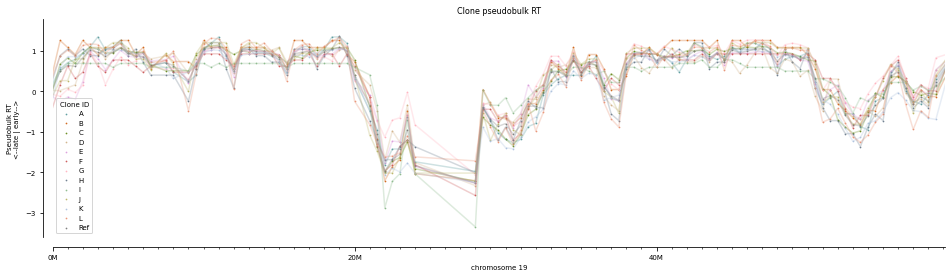

In [16]:

def plot_clone_rt_profiles(rt, ax, chrom_labels_to_remove=[], chromosome=None):
    cols = [x for x in rt.columns if x.startswith('pseudobulk_clone') and x.endswith('model_rep_state')]
    clones = [x.split('_')[1].replace('clone', '') for x in cols]
    clone_cmap = get_clone_cmap()
    # add a color for the Ref
    clone_cmap['Ref'] = 'grey'

    for clone_id, col in zip(clones, cols):
        # plot the whole genome
        if chromosome is None:
            plot_cell_cn_profile2(
                ax, rt, col, color=clone_cmap[clone_id], rawy=True,
                max_cn=None, scale_data=False, lines=True, label=clone_id,
                s=0.5, rasterized=True, chrom_labels_to_remove=chrom_labels_to_remove
            )
        # zoom in on chr1
        else:
            plot_cell_cn_profile2(
                ax, rt, col, color=clone_cmap[clone_id], chromosome=chromosome, rawy=True,
                max_cn=None, scale_data=False, lines=True, label=clone_id,
                s=0.5, rasterized=True
            )

    ax.set_title('Clone pseudobulk RT')
    ax.legend(title='Clone ID')
    ax.set_ylabel('Pseudobulk RT\n<--late | early-->')

    return ax

# plot the pseudobulk RT profiles for SA906a
fig, ax = plt.subplots(1, 1, figsize=(16,4))
plot_clone_rt_profiles(rt_sa906b, ax, chromosome='19')
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


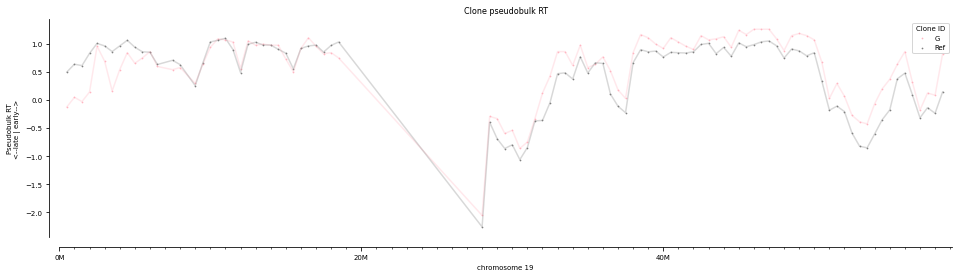

In [17]:
# repeat the subplot above but only show the region of the chr6 loss
fig, ax = plt.subplots(1, 1, figsize=(16,4))
plot_clone_rt_profiles(rt_SA906b_chr19[['chr', 'start', 'end', 'pseudobulk_cloneG_model_rep_state', 'pseudobulk_cloneRef_model_rep_state']], ax, chromosome='19')
plt.show()

### Load the SA906b clone G pseudoublk CN profile and plot the chr19 gain and loss events

In [18]:
cn_sa906b = pd.read_csv('../../analysis/sig_lines/SA906b/cn_pseudobulks.tsv', sep='\t', dtype={'chr': str})
# convert the chr column to a category
cn_sa906b.chr = cn_sa906b.chr.astype('category')
# add a column named end which is 500kb after the start
cn_sa906b['end'] = cn_sa906b.start + 500000 -1
cn_sa906b.head()

,chr,start,dataset_SA906b,sample_SA906,clone_A,clone_B,clone_C,clone_D,clone_E,clone_F,clone_G,clone_H,clone_I,clone_J,clone_K,clone_L,end
0,1,1000001,2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1500000
1,1,1500001,2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2000000
2,1,2000001,2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2500000
3,1,3000001,2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3500000
4,1,4000001,2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4500000


In [19]:
# drop the sample_SA906 column and rename the dataset_SA906b column into the clone_Ref column
cn_sa906b = cn_sa906b.drop(columns=['sample_SA906']).rename(columns={'dataset_SA906b': 'clone_Ref'})
cn_sa906b.head()

,chr,start,clone_Ref,clone_A,clone_B,clone_C,clone_D,clone_E,clone_F,clone_G,clone_H,clone_I,clone_J,clone_K,clone_L,end
0,1,1000001,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1500000
1,1,1500001,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2000000
2,1,2000001,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2500000
3,1,3000001,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3500000
4,1,4000001,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4500000


In [20]:
# the regions that are not gains or losses on chr19 are centromeric regions that should be filtered out
cn_SA906b_chr19 = cn_sa906b[((cn_sa906b.start >= chr19_loss_start) | (cn_sa906b.end <= chr19_gain_end)) & (cn_sa906b.chr == '19')]
cn_SA906b_chr19.head()

,chr,start,clone_Ref,clone_A,clone_B,clone_C,clone_D,clone_E,clone_F,clone_G,clone_H,clone_I,clone_J,clone_K,clone_L,end
2140,19,500001,2,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,1000000
2141,19,1000001,2,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,1500000
2142,19,1500001,2,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2000000
2143,19,2000001,2,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2500000
2144,19,2500001,2,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,3000000


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a f

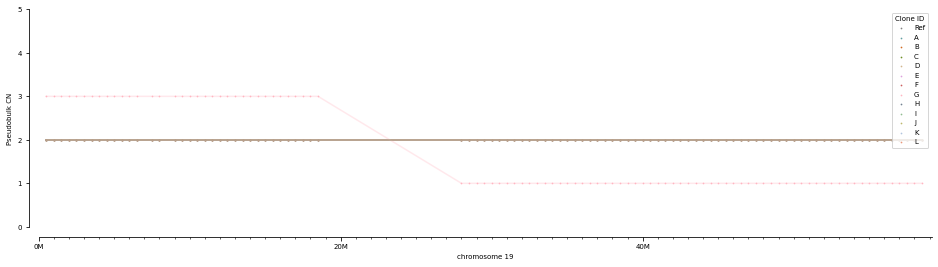

In [21]:
def plot_clone_cn_profiles(cn, ax, chrom_labels_to_remove=[], chromosome=None):

    # find all the columns that are not chr, start, or end
    cols = [x for x in cn.columns if x not in ['chr', 'start', 'end']]
    clones = [x.split('_')[1] for x in cols]
    clone_cmap = get_clone_cmap()
    # add a color for the Ref
    clone_cmap['Ref'] = 'grey'

    for clone_id, col in zip(clones, cols):
        # plot the whole genome
        if chromosome is None:
            plot_cell_cn_profile2(
                ax, cn, col, color=clone_cmap[clone_id], rawy=True,
                max_cn=None, scale_data=False, lines=True, label=clone_id,
                s=0.5, rasterized=True, chrom_labels_to_remove=chrom_labels_to_remove
            )
        # zoom in on chr1
        else:
            plot_cell_cn_profile2(
                ax, cn, col, color=clone_cmap[clone_id], chromosome=chromosome, rawy=True,
                max_cn=None, scale_data=False, lines=True, label=clone_id,
                s=0.5, rasterized=True
            )

    # reset the y-axis limits to be 0-5
    ax.set_ylim(0, 5)
    ax.legend(title='Clone ID')
    ax.set_ylabel('Pseudobulk CN')

    return ax

# plot the pseudobulk RT profiles for SA906a
fig, ax = plt.subplots(1, 1, figsize=(16,4))
plot_clone_cn_profiles(cn_SA906b_chr19, ax, chromosome='19')
plt.show()

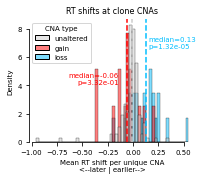

In [22]:
def plot_rt_shift_hist_per_event(unique_events, ax):
    # instead of a violin plot, show the histogram of clone_rt_diff with a hue of clone_cna_type
    unique_events['CNA type'] = unique_events['clone_cna_type']
    # plot the histogram of mean_rt_diff with a hue of clone_cna_type
    sns.histplot(
        data=unique_events, x='mean_rt_diff', hue='CNA type', 
        hue_order=['unaltered', 'gain', 'loss'], palette=get_cna_cmap(), 
        common_norm=False, stat='density', ax=ax
    )

    # compute the p-values between loss-unaltered and gain-unaltered
    # get the y-values for the loss-unaltered and gain-unaltered comparisons
    loss = unique_events[unique_events.clone_cna_type == 'loss'].mean_rt_diff
    unaltered = unique_events[unique_events.clone_cna_type == 'unaltered'].mean_rt_diff
    gain = unique_events[unique_events.clone_cna_type == 'gain'].mean_rt_diff
    # compute the p-value between loss-unaltered and gain-unaltered
    # multiply by 2 to get the bonferonni corrected p-value
    loss_unaltered_pval = stats.ttest_ind(loss, unaltered)[1] * 2
    gain_unaltered_pval = stats.ttest_ind(gain, unaltered)[1] * 2

    # annotate the median of each distribution with a dashed vertical line
    # annotate the line with the median value as text with 2 decimal places
    text_offset = 0.08
    text_height = 4.5
    loss_median = unique_events[unique_events.clone_cna_type=='loss'].mean_rt_diff.median()
    ax.axvline(x=loss_median, color=get_cna_cmap()['loss'], linestyle='--')
    ax.text(x=loss_median+0.02, y=7, s='median={:.2f}\np={:.2e}'.format(loss_median, loss_unaltered_pval), color=get_cna_cmap()['loss'], ha='left', va='center')
    unaltered_median = unique_events[unique_events.clone_cna_type=='unaltered'].mean_rt_diff.median()
    ax.axvline(x=unaltered_median, color=get_cna_cmap()['unaltered'], linestyle='--')
    # ax.text(x=unaltered_median, y=9, s='median={:.2f}'.format(unaltered_median), color=get_cna_cmap()['unaltered'], ha='left', va='center')
    gain_median = unique_events[unique_events.clone_cna_type=='gain'].mean_rt_diff.median()
    ax.axvline(x=gain_median, color=get_cna_cmap()['gain'], linestyle='--')
    ax.text(x=gain_median-text_offset, y=text_height, s='median={:.2f}\np={:.2e}'.format(gain_median, gain_unaltered_pval), color=get_cna_cmap()['gain'], ha='right', va='center')

    ax.set_xlabel('Mean RT shift per unique CNA\n<--later | earlier-->')
    ax.set_title('RT shifts at clone CNAs')


    sns.despine(ax=ax, trim=True, offset=0)


fig, ax = plt.subplots(1, 1, figsize=(3, 2.25))
plot_rt_shift_hist_per_event(unique_events, ax)
plt.show()

### Make a multi-panel figure showing a combination of all these subplots

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:26

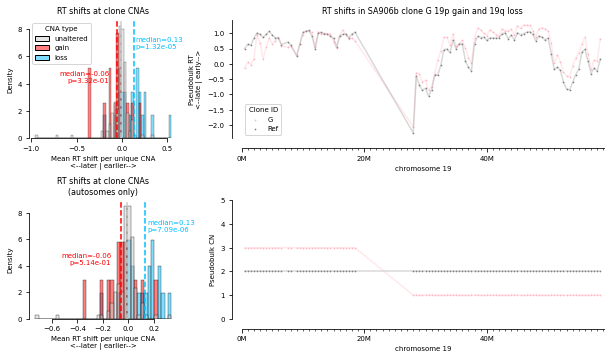

In [23]:
# create a 3x3 grid of subplots
fig, ax = plt.subplots(2, 3, figsize=(8.5, 5), tight_layout=True)

# merge the middle and right subplots in the top row into one subplot
ax[0, 1].remove()
ax[0, 2].remove()
ax[0, 1] = fig.add_subplot(2, 3, (2, 3))

# merge the middle and right subplots in the second row into one subplot
ax[1, 1].remove()
ax[1, 2].remove()
ax[1, 1] = fig.add_subplot(2, 3, (5, 6))


# plot the RT shifts per unique CNA in the top left subplot
plot_rt_shift_hist_per_event(unique_events, ax[0, 0])

# plot the RT shifts per unique CNA in an autosome (chr!='X') in the middle left subplot
autosome_unique_events = unique_events[unique_events.chr != 'X']
plot_rt_shift_hist_per_event(autosome_unique_events, ax[1, 0])
# add the suffix (autosomes only) to the title
ax[1, 0].set_title('RT shifts at clone CNAs\n(autosomes only)')
ax[1, 0].get_legend().remove()

# plot the RT shifts at SA906b clone G 19p gain & 19q loss in the bottom two rows
plot_clone_rt_profiles(rt_SA906b_chr19[['chr', 'start', 'end', 'pseudobulk_cloneG_model_rep_state', 'pseudobulk_cloneRef_model_rep_state']], ax[0, 1], chromosome='19')
ax[0, 1].set_title('RT shifts in SA906b clone G 19p gain and 19q loss')

plot_clone_cn_profiles(cn_SA906b_chr19[['chr', 'start', 'end', 'clone_Ref', 'clone_G']], ax[1, 1], chromosome='19')
ax[1, 1].get_legend().remove()

# save the figure
fig.savefig('../../manuscript/extended_data_figs/figED6.pdf', dpi=300, bbox_inches='tight')

plt.show()